In [2]:
!pip install eli5

     |████████████████████████████████| 112kB 3.5MB/s 


In [0]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

import seaborn as sns

import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt

from ast import literal_eval
from collections import Counter
from tqdm import tqdm_notebook

In [5]:
cd /content/drive/My Drive/Colab Notebooks/data_workshop

/content/drive/My Drive/Colab Notebooks/data_workshop


In [6]:
ls

data/  HelloGithub.ipynb  LICENSE  matrix_one/  README.md


In [7]:
ls data

men_shoes.csv


In [43]:
df = pd.read_csv('data/men_shoes.csv')
df.sample()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,asins,brand,categories,colors,count,dateadded,dateupdated,descriptions,dimension,ean,features,flavors,imageurls,isbn,keys,manufacturer,manufacturernumber,merchants,name,prices_amountmin,prices_amountmax,prices_availability,prices_color,prices_condition,prices_count,prices_currency,prices_dateadded,prices_dateseen,prices_flavor,prices_issale,prices_merchant,prices_offer,prices_returnpolicy,prices_shipping,prices_size,prices_source,prices_sourceurls,prices_warranty,quantities,reviews,sizes,skus,sourceurls,upc,vin,websiteids,weight
8724,AVpe8LmR1cnluZ0-aUEU,NaN,Nobles Health Care Products,"Clothing,Shoes,Men's Shoes,All Men's Shoes",Brown,NaN,2017-01-14T19:32:58Z,2017-01-14T19:32:58Z,"[{""dateSeen"":[""2017-01-14T19:32:58Z""],""sourceU...",NaN,6.869105e+11,"[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Coun...",NaN,https://i5.walmartimages.com/asr/bf9b593f-a0d4...,NaN,"686910484569,0686910484569",Nobles Health Care Products,NaN,"[{""dateSeen"":[""2017-01-14T19:32:58Z""],""name"":""...",Slipper Socks - Size 9-11 - Pack of 3 Pairs - ...,11.95,11.95,NaN,NaN,new,NaN,USD,2017-01-14T19:32:58Z,2017-01-13T00:00:00Z,NaN,False,Nobles Health Care Product Solutions - Walmart...,NaN,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/Slipper-Socks-Size-...,NaN,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/Slipper-Socks-Size-...,6.869105e+11,NaN,NaN,NaN


# 1. Identification of usefull features

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18280 entries, 0 to 18279
Data columns (total 48 columns):
id                     18280 non-null object
asins                  2161 non-null object
brand                  18263 non-null object
categories             18280 non-null object
colors                 10344 non-null object
count                  0 non-null float64
dateadded              18280 non-null object
dateupdated            18280 non-null object
descriptions           9704 non-null object
dimension              2968 non-null object
ean                    9690 non-null float64
features               13299 non-null object
flavors                0 non-null float64
imageurls              17255 non-null object
isbn                   0 non-null float64
keys                   18280 non-null object
manufacturer           6296 non-null object
manufacturernumber     14309 non-null object
merchants              13018 non-null object
name                   18280 non-null object
pric

In [45]:
df.describe()

,count,ean,flavors,isbn,prices_amountmin,prices_amountmax,prices_count,prices_source,quantities,upc,vin,websiteids
count,0.0,9.690000e+03,0.0,0.0,18280.000000,18280.000000,0.0,0.0,0.0,1.048800e+04,0.0,0.0
mean,NaN,8.094490e+11,NaN,NaN,93.539522,96.117449,NaN,NaN,NaN,6.920961e+11,NaN,NaN
std,NaN,9.209031e+11,NaN,NaN,97.774193,100.150618,NaN,NaN,NaN,2.883291e+11,NaN,NaN
min,NaN,1.014667e+07,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,1.014667e+07,NaN,NaN
25%,NaN,6.759119e+11,NaN,NaN,34.990000,35.380000,NaN,NaN,NaN,6.668984e+11,NaN,NaN
50%,NaN,8.405971e+11,NaN,NaN,64.950000,65.000000,NaN,NaN,NaN,8.274430e+11,NaN,NaN
75%,NaN,8.871197e+11,NaN,NaN,110.347500,115.000000,NaN,NaN,NaN,8.869544e+11,NaN,NaN
max,NaN,8.907198e+12,NaN,NaN,890.000000,890.000000,NaN,NaN,NaN,9.562614e+11,NaN,NaN


There are multiple columns containing only NULL values. Let's drop them

In [0]:
df.dropna(axis=1, how='all', inplace=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18280 entries, 0 to 18279
Data columns (total 40 columns):
id                     18280 non-null object
asins                  2161 non-null object
brand                  18263 non-null object
categories             18280 non-null object
colors                 10344 non-null object
dateadded              18280 non-null object
dateupdated            18280 non-null object
descriptions           9704 non-null object
dimension              2968 non-null object
ean                    9690 non-null float64
features               13299 non-null object
imageurls              17255 non-null object
keys                   18280 non-null object
manufacturer           6296 non-null object
manufacturernumber     14309 non-null object
merchants              13018 non-null object
name                   18280 non-null object
prices_amountmin       18280 non-null float64
prices_amountmax       18280 non-null float64
prices_availability    114 non-null ob

Our assumption is to predict `price_amountmin` values. Let's find out other `prices_` cols too see which are usable for us.

In [48]:
price_cols = [col for col in df.columns if col.startswith('prices_')]
df[ price_cols ].sample(5)

,prices_amountmin,prices_amountmax,prices_availability,prices_color,prices_condition,prices_currency,prices_dateadded,prices_dateseen,prices_flavor,prices_issale,prices_merchant,prices_offer,prices_returnpolicy,prices_shipping,prices_size,prices_sourceurls,prices_warranty
14808,16.99,16.99,NaN,NaN,new,USD,2017-01-14T19:32:45Z,2017-01-13T00:00:00Z,NaN,False,Crazy For Bargains LLC - Walmart.com,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/Mossy-Oak-Men-s-Gre...,NaN
11219,66.95,66.95,NaN,NaN,new,USD,2017-01-17T19:00:35Z,2017-01-17T19:00:35Z,NaN,False,OrthoticShop.com - Walmart.com,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/162499797,NaN
16361,94.95,94.95,NaN,NaN,New,USD,2016-03-24T07:15:13Z,2016-04-18T00:00:00Z,NaN,False,STAND UP Ranchers,NaN,NaN,USD 0.01,NaN,http://www.newegg.com/Product/Product.aspx?Ite...,NaN
11721,19.99,19.99,NaN,NaN,New with box,USD,2016-03-04T02:52:24Z,2016-03-03T00:00:00Z,NaN,False,NaN,NaN,NaN,USD 6.95,NaN,http://www.ebay.com/itm/REEBOK-UL-6000-SNEAKER...,NaN
3802,56.90,56.90,NaN,NaN,new,USD,2016-11-01T09:40:33Z,2016-10-31T00:00:00Z,NaN,False,shoezoo - Walmart.com,NaN,NaN,NaN,NaN,https://www.walmart.com/ip/Nike-Men-s-Son-Of-F...,NaN


In [49]:
df[ price_cols ].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18280 entries, 0 to 18279
Data columns (total 17 columns):
prices_amountmin       18280 non-null float64
prices_amountmax       18280 non-null float64
prices_availability    114 non-null object
prices_color           558 non-null object
prices_condition       11675 non-null object
prices_currency        18280 non-null object
prices_dateadded       18280 non-null object
prices_dateseen        18280 non-null object
prices_flavor          1 non-null object
prices_issale          18280 non-null bool
prices_merchant        13160 non-null object
prices_offer           5874 non-null object
prices_returnpolicy    798 non-null object
prices_shipping        4906 non-null object
prices_size            486 non-null object
prices_sourceurls      18265 non-null object
prices_warranty        42 non-null object
dtypes: bool(1), float64(2), object(14)
memory usage: 2.2+ MB


In [50]:
def print_counts(cols):
    for col in cols:
        print(f'''

    -------------------------{col}-------------------------
    {df[col].value_counts()}
        ''')
print_counts(price_cols)        



    -------------------------prices_amountmin-------------------------
    65.00     228
19.99     189
59.99     187
39.99     186
49.99     180
         ... 
175.34      1
108.64      1
92.88       1
31.96       1
92.54       1
Name: prices_amountmin, Length: 5394, dtype: int64
        


    -------------------------prices_amountmax-------------------------
    65.00     229
19.99     188
59.99     184
49.99     181
39.99     178
         ... 
378.00      1
65.42       1
186.41      1
61.34       1
82.44       1
Name: prices_amountmax, Length: 5267, dtype: int64
        


    -------------------------prices_availability-------------------------
    true            65
Yes             21
Out of Stock    16
yes              9
false            3
Name: prices_availability, dtype: int64
        


    -------------------------prices_color-------------------------
    Black                                                          50
Tan                                                    

Some conclusions:
* `prices_amountmax` - to drop (close values as our y)
* `prices_availability` - to drop (little representation)
* `prices_color` - lets save this col, at least temporarily (later compared with `params`)
* `prices_condition` - may be usefull (shoes in good conditions should be more expensive)
* `prices_currency` - all prices are given in USD, redundant column -> to drop
* `prices_issale` - may be usefull (shoes from sale should be theoreticly cheaper)
* `prices_merchant` - may be usefull (maybe in specific shops shoes are generally cheaper/more expensive)
* `prices_flavor` - to drop (one not-null observation)
* `prices_dateseen`, `prices_dateadded` - fully not-null, worth to take into account year/month/day/weekend/black friday/christmass etc. But what does mean 'date seen'?
* `prices_offer` - 1/3 not-null values, let's include this col
* `prices_returnpolicy` - to drop
* `prices_shipping` - included
* `prices_sourceurls` - to drop
* `prices_size` - only 500 non-null - to drop
* `prices_warranty` - I'll drop this one





In [0]:
cols_to_drop = ['prices_amountmax', 'prices_availability', 'prices_currency', 'prices_flavor', 'prices_returnpolicy', 'prices_sourceurls', 'prices_size', 'prices_warranty']
df.drop(cols_to_drop, axis=1, inplace=True)

In [52]:
non_price_cols = [col for col in df.columns if 'prices_' not in col]
df[ non_price_cols ].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18280 entries, 0 to 18279
Data columns (total 23 columns):
id                    18280 non-null object
asins                 2161 non-null object
brand                 18263 non-null object
categories            18280 non-null object
colors                10344 non-null object
dateadded             18280 non-null object
dateupdated           18280 non-null object
descriptions          9704 non-null object
dimension             2968 non-null object
ean                   9690 non-null float64
features              13299 non-null object
imageurls             17255 non-null object
keys                  18280 non-null object
manufacturer          6296 non-null object
manufacturernumber    14309 non-null object
merchants             13018 non-null object
name                  18280 non-null object
reviews               1592 non-null object
sizes                 5920 non-null object
skus                  8120 non-null object
sourceurls        

In [0]:
df.drop(['asins', 'dimension', 'reviews', 'weight', 'ean', 'skus', 'upc'], axis=1, inplace=True)

Some less important features have been dropped. Summary before next stage:

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18280 entries, 0 to 18279
Data columns (total 25 columns):
id                    18280 non-null object
brand                 18263 non-null object
categories            18280 non-null object
colors                10344 non-null object
dateadded             18280 non-null object
dateupdated           18280 non-null object
descriptions          9704 non-null object
features              13299 non-null object
imageurls             17255 non-null object
keys                  18280 non-null object
manufacturer          6296 non-null object
manufacturernumber    14309 non-null object
merchants             13018 non-null object
name                  18280 non-null object
prices_amountmin      18280 non-null float64
prices_color          558 non-null object
prices_condition      11675 non-null object
prices_dateadded      18280 non-null object
prices_dateseen       18280 non-null object
prices_issale         18280 non-null bool
prices_merchant 

In [55]:
df.columns

Index(['id', 'brand', 'categories', 'colors', 'dateadded', 'dateupdated',
       'descriptions', 'features', 'imageurls', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_color', 'prices_condition', 'prices_dateadded',
       'prices_dateseen', 'prices_issale', 'prices_merchant', 'prices_offer',
       'prices_shipping', 'sizes', 'sourceurls'],
      dtype='object')

# 2. Parse `features` column

In [56]:
df.features.sample(5).values

array(['[{"key":"Heel Height","value":["1 Inches"]},{"key":"Material","value":["Leather"]},{"key":"Gender","value":["Men"]},{"key":"Shoe Category","value":["Men\'s Shoes"]},{"key":"Fabric Content","value":["Leather"]},{"key":"Color","value":["Black"]},{"key":"Model","value":["103261"]},{"key":"Shoe Closure","value":["Front Lace"]},{"key":"Casual & Dress Shoe Style","value":["Fashion Shoes"]},{"key":"Manufacturer Part Number","value":["103261"]},{"key":"Brand","value":["Rush by Gordon Rush"]},{"key":"Age Group","value":["Adult"]}]',
       '[{"key":"Heel Height","value":["0 Inches"]},{"key":"Gender","value":["Men"]},{"key":"Shoe Category","value":["Men\'s Shoes"]},{"key":"Brand","value":["Pajar"]},{"key":"Is Waterproof","value":["Y"]},{"key":"Shoe Width","value":["Medium (D, M)"]}]',
       '[{"key":"MPN","value":["889768_XL"]},{"key":"Condition","value":["New with tags"]},{"key":"EAN","value":["0883028976881"]}]',
       '[{"key":"Style","value":["Cleats"]},{"key":"Condition","value":[

In [0]:
def parse_features(x):
    output_dict = dict()
    if str(x) == 'nan': return output_dict

    features = literal_eval(x.replace('\\"', '"'))
    for item in features:
        key = item['key'].lower().strip()
        value = item['value'][0].lower().strip()
        output_dict[key] = value
    return output_dict

df['features_parsed'] = df['features'].map(parse_features)

In [58]:
df[['features_parsed', 'features']].sample(5)

,features_parsed,features
15924,"{'season': 'all-season', 'material': 'leather'...","[{""key"":""Season"",""value"":[""All-Season""]},{""key..."
15370,{},NaN
10991,"{'gender': 'men', 'shoe category': 'men's shoe...","[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe..."
3093,{},NaN
4820,"{'material': 'synthetic', 'gender': 'men', 'sh...","[{""key"":""Material"",""value"":[""Synthetic""]},{""ke..."


### Create columns based on nested features names
Let's get key names from features and count how often they occur. `Counter` from `collections` lib is very usefull to do this.

In [59]:
keys_cnt = Counter()
df['features_parsed'].map( lambda x: keys_cnt.update(x.keys()) )

len(keys_cnt)

476

Top keys:

In [60]:
df_features_counters = pd.DataFrame(keys_cnt.items(), columns=['key', 'counter'])
df_features_counters.nlargest(10, columns='counter')

,key,counter
0,gender,9172
5,brand,8889
3,color,8735
4,manufacturer part number,6627
10,material,6381
13,age group,5054
2,shoe category,4456
16,model,4329
1,shoe size,4264
15,size,3916


Let's focus on most common columns.

In [61]:
top_keys = df_features_counters[ df_features_counters.counter > 500 ].key.values
top_keys

array(['gender', 'shoe size', 'shoe category', 'color',
       'manufacturer part number', 'brand', 'shipping weight (in pounds)',
       'condition', 'manufacturer_part_number', 'heel height', 'material',
       'fabric material', 'casual & dress shoe style', 'age group',
       'shoe width', 'size', 'model', 'shoe closure', 'style',
       'country of origin - assembly',
       'assembled product dimensions (l x w x h)', 'fabric content',
       'country of origin - components', 'sport', 'type',
       'country/region of manufacture', 'occasion', 'season'],
      dtype=object)

In [62]:
len(top_keys)

28

In [63]:
def get_name_feat(key):
    return 'feat_' + key

for key in tqdm_notebook(top_keys):
    df[get_name_feat(key)] =  df.features_parsed.map( lambda feats: feats[key] if key in feats else np.nan)

In [64]:
df.columns

Index(['id', 'brand', 'categories', 'colors', 'dateadded', 'dateupdated',
       'descriptions', 'features', 'imageurls', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_color', 'prices_condition', 'prices_dateadded',
       'prices_dateseen', 'prices_issale', 'prices_merchant', 'prices_offer',
       'prices_shipping', 'sizes', 'sourceurls', 'features_parsed',
       'feat_gender', 'feat_shoe size', 'feat_shoe category', 'feat_color',
       'feat_manufacturer part number', 'feat_brand',
       'feat_shipping weight (in pounds)', 'feat_condition',
       'feat_manufacturer_part_number', 'feat_heel height', 'feat_material',
       'feat_fabric material', 'feat_casual & dress shoe style',
       'feat_age group', 'feat_shoe width', 'feat_size', 'feat_model',
       'feat_shoe closure', 'feat_style', 'feat_country of origin - assembly',
       'feat_assembled product dimensions (l x w x h)', 'feat_fabric content',
       'feat_

Let's go through every new feature

# 3. Detailed feature engineering

## 3a. Gender

In [65]:
df.feat_gender.value_counts()

men                     7471
unisex                  1098
boys                     147
male                     123
women                    112
girls                     67
men's                     64
mens                      39
women ,�� men             15
unisex adults              9
adult unisex               7
men / women                5
unisex, mens, womens       4
female                     4
girls'                     4
women's                    2
unisex adult               1
Name: feat_gender, dtype: int64

In [66]:
genders = {'men': ["men's", "men", "male", "mens"],
           'women': ["women", "female", "women's" ],
           'unisex': ['unisex', 'women ,�� men', 'unisex adults', 'adult unisex','men / women', 'unisex, mens, womens', 'unisex adult'],
           'girls': ['girls', "girls'"]}

def replace_gender(original_gender):
    for key in genders:
        if original_gender in genders[key]:
            return key
    return original_gender
            
df.feat_gender = df.feat_gender.apply(lambda x: replace_gender(x))
df.feat_gender.value_counts()

men       7697
unisex    1139
boys       147
women      118
girls       71
Name: feat_gender, dtype: int64

Let's replace spaces in colnames 

In [0]:
df.columns = [col.replace(' ', '_') for col in df.columns]

In [68]:
df.columns

Index(['id', 'brand', 'categories', 'colors', 'dateadded', 'dateupdated',
       'descriptions', 'features', 'imageurls', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_color', 'prices_condition', 'prices_dateadded',
       'prices_dateseen', 'prices_issale', 'prices_merchant', 'prices_offer',
       'prices_shipping', 'sizes', 'sourceurls', 'features_parsed',
       'feat_gender', 'feat_shoe_size', 'feat_shoe_category', 'feat_color',
       'feat_manufacturer_part_number', 'feat_brand',
       'feat_shipping_weight_(in_pounds)', 'feat_condition',
       'feat_manufacturer_part_number', 'feat_heel_height', 'feat_material',
       'feat_fabric_material', 'feat_casual_&_dress_shoe_style',
       'feat_age_group', 'feat_shoe_width', 'feat_size', 'feat_model',
       'feat_shoe_closure', 'feat_style', 'feat_country_of_origin_-_assembly',
       'feat_assembled_product_dimensions_(l_x_w_x_h)', 'feat_fabric_content',
       'feat_

## 3b. Brands

In [89]:
df.brand.value_counts().sum()

18263

In [91]:
df.feat_brand.value_counts().sum()

8889

In [95]:
df[ ['brand', 'feat_brand'] ].drop_duplicates().sample(20)

,brand,feat_brand
14585,GUESS,guess
1999,THE ORIGINAL MUCK BOOT CO.,the original muck boot co.
9044,CATAPULT,NaN
3917,Born,NaN
4448,LaCrosse Footwear,NaN
3956,Marvel,NaN
12429,Majestic,NaN
1461,Bogs,bogs
9384,Red Wing Heritage,NaN
2074,Mountain Hardwear,NaN


`df.brand` looks better than `df.feat_brand` so it's worth to focus on first one.

In [97]:
df[df.brand.apply(lambda x: 'nike' in str(x).lower())].brand.value_counts()

Nike                      1709
NIKE                        59
nike                         9
Nike Golf                    6
Nike Jordan Future Low       2
NIKE AIR JORDAN I            1
NIKE - Kobe                  1
NIKE AIR JORDAN              1
NIKE Air Jordan              1
Nike Lunarglide 7            1
Nike SB                      1
Nike Air Jordan              1
Name: brand, dtype: int64

In [0]:
df.brand = df.brand.str.lower().str.strip().str.replace('-', ' ').str.replace('\s\s+', ' ', regex=True)

In [115]:
brands_counts = pd.DataFrame(df.brand.value_counts())
brands_counts

,brand
nike,1777
puma,609
ralph lauren,526
vans,386
new balance,371
...,...
slipperooz,1
gap,1
whose lemon,1
zorrie,1


In [289]:
brands_counts[brands_counts.brand < 10].shape

(1396, 1)

Over 1700 brands, where 1400 have below 10 observations. If we use all of them into the model, we will get 1700 dummy variables. Instead I'll get most frequent brands and generate 10 clusters for other brands.  

In [202]:
brands_gr = df[['brand', 'prices_amountmin']].groupby('brand').aggregate(['mean', 'std','count'])
brands_gr.fillna(value=0, inplace=True)
brands_gr.sample(5)

prices_amountmin                  
                              mean         std count
brand                                               
lakai                       54.995   21.325170     8
ermenegildo zegna          408.330  190.421944     3
care apparel                15.990    0.000000     1
harley davidson             46.660   57.772775     5
1883 by wolverine          149.950    0.000000     1

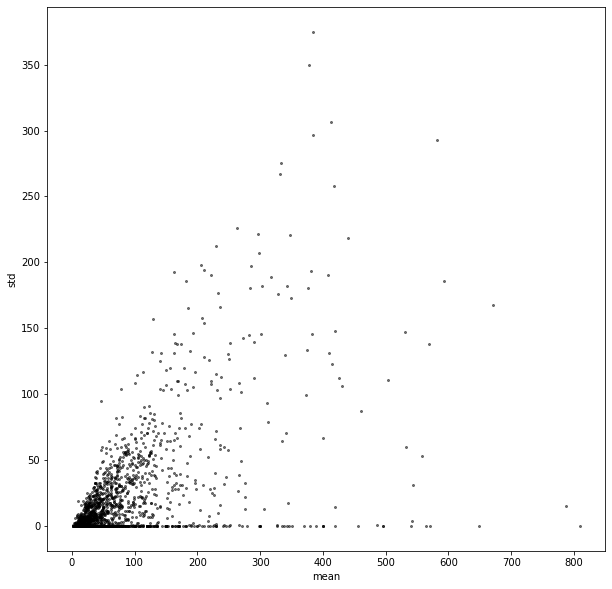

In [203]:
brands_gr['prices_amountmin'][['mean', 'std']].plot.scatter(x='mean', y='std', figsize=(10,10), s=4, c='black', alpha=0.5);

In [204]:
brands_gr['prices_amountmin'].isna().sum()

mean     0
std      0
count    0
dtype: int64

In [0]:
brands_gr.reset_index(inplace=True)

In [0]:
brands_gr.columns = brands_gr.columns.droplevel()

In [0]:
brands_gr_small = brands_gr[brands_gr['count'] < 100]
X = brands_gr_small[['mean', 'std']]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

In [291]:
brands_gr_small['cluster'] = pd.Series(kmeans.labels_)
brands_gr_small.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,brand,mean,std,count,cluster,cluster_
0,"""""ganesha handicraft """"",44.141429,8.949302,7,9,1.0
1,"""""handmade""""",41.979500,17.283309,20,9,1.0
2,1031,44.510000,0.000000,1,9,1.0
3,12 step gold,49.975000,14.177491,2,9,1.0
4,14k co.,171.441944,30.788931,36,7,7.0


In [0]:
brands_gr_small.reset_index(inplace=True, drop=True)
brands_gr_small.head()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


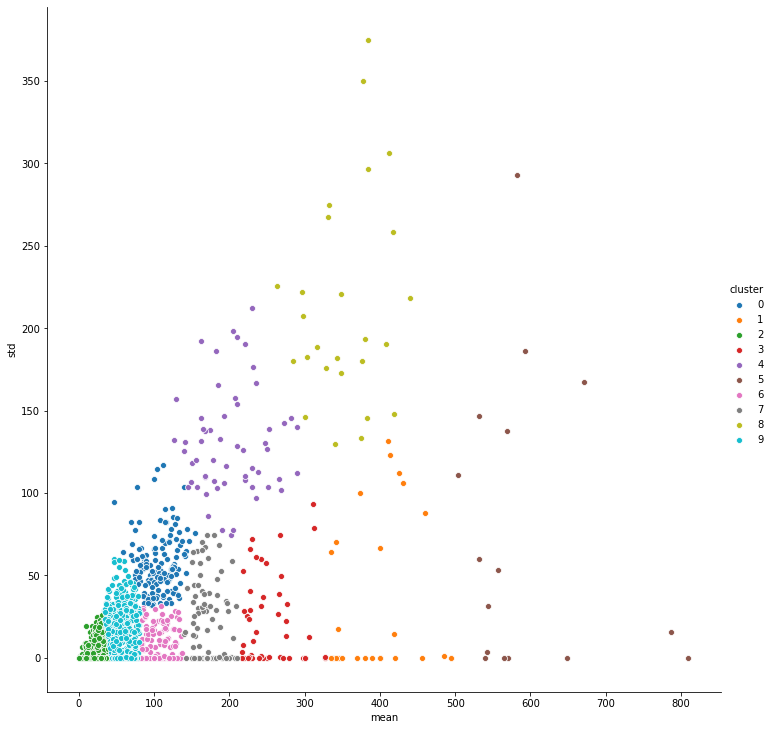

In [293]:
sns.pairplot(x_vars=['mean'], y_vars=['std'], data=brands_gr_small, hue='cluster', size=10);

In [280]:
df.head(1)

,id,brand,categories,colors,dateadded,dateupdated,descriptions,features,imageurls,keys,manufacturer,manufacturernumber,merchants,name,prices_amountmin,prices_color,prices_condition,prices_dateadded,prices_dateseen,prices_issale,prices_merchant,prices_offer,prices_shipping,sizes,sourceurls,features_parsed,feat_gender,feat_shoe_size,feat_shoe_category,feat_color,feat_manufacturer_part_number,feat_brand,feat_shipping_weight_(in_pounds),feat_condition,feat_manufacturer_part_number,feat_heel_height,feat_material,feat_fabric_material,feat_casual_&_dress_shoe_style,feat_age_group,feat_shoe_width,feat_size,feat_model,feat_shoe_closure,feat_style,feat_country_of_origin_-_assembly,feat_assembled_product_dimensions_(l_x_w_x_h),feat_fabric_content,feat_country_of_origin_-_components,feat_sport,feat_type,feat_country/region_of_manufacture,feat_occasion,feat_season
0,AVpfHrJ6ilAPnD_xVXOI,josmo,"Clothing,Shoes,Men's Shoes,All Men's Shoes",NaN,2016-11-07T00:45:12Z,2016-11-07T00:45:12Z,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""sourceU...","[{""key"":""Gender"",""value"":[""Men""]},{""key"":""Shoe...",https://i5.walmartimages.com/asr/13ac3d61-003c...,"josmo/8190wnavy75,699302044036,0699302044036",NaN,8190-W-NAVY-7.5,"[{""dateSeen"":[""2016-11-07T00:45:12Z""],""name"":""...","Josmo 8190 Plain Infant Walking Shoes, Navy - ...",39.89,NaN,NaN,2016-11-07T00:45:12Z,2016-11-05T00:00:00Z,True,NaN,REDUCED USD 12.10,NaN,NaN,https://www.walmart.com/ip/Josmo-8190-Plain-In...,"{'gender': 'men', 'shoe size': 'm', 'shoe cate...",men,m,men's shoes,multicolor,8190-w-navy-7.5,josmo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df = df.merge(brands_gr_small[['brand', 'cluster']], how='left', on='brand')

In [0]:
frequent_brands = df[ df.cluster.isna() ].brand.unique()
df['frequent_brands'] = df.brand.apply(lambda x: x if x in frequent_brands else np.nan)

In [299]:
df[['brand', 'frequent_brands', 'cluster']]

,brand,frequent_brands,cluster
0,josmo,NaN,6.0
1,josmo,NaN,6.0
2,servus by honeywell,NaN,6.0
3,servus by honeywell,NaN,6.0
4,servus by honeywell,NaN,6.0
...,...,...,...
18275,"xray, xray",NaN,1.0
18276,fila,NaN,6.0
18277,seek optics,NaN,1.0
18278,seek optics,NaN,1.0


Now we have prepared brands. The purpose is to create dummy variables based on most frequent brands and clustered brands

In [0]:
df = pd.get_dummies(df, columns=['frequent_brands', 'cluster', 'feat_gender'])

## 3c. Colors

In [325]:
df[['colors','prices_color','feat_color']].isna().sum()

colors           7936
prices_color    17722
feat_color       9545
dtype: int64

`colors` column seems to be best. Maybe its worth to merge them?

In [0]:
df['color_grouped'] = df[['colors','prices_color','feat_color']].apply(lambda x: ','.join(x[x.notnull()]), axis=1)
df.color_grouped = df.color_grouped.str.lower()
df.color_grouped = df.color_grouped.apply(lambda x:  sorted(list( set(x.replace('/', ',').split(',')) ))[0].strip())

In [375]:
df.color_grouped.value_counts().nlargest(30).index

Index(['', 'black', 'brown', 'blue', 'multicolor', 'gray', 'white', 'beige',
       'red', 'green', 'multi-color', 'yellow', 'tan', 'dark brown', 'orange',
       'grey', 'silver', 'gold', 'brass', 'navy', 'newport navy',
       'blackblack mesh', 'multi', 'charcoal grey', 'blacks', 'multi-colored',
       'other', 'pink', 'khaki', 'assorted'],
      dtype='object')

In [377]:
freq_colors = df.color_grouped.value_counts().nlargest(30).index[1:]
freq_colors

Index(['black', 'brown', 'blue', 'multicolor', 'gray', 'white', 'beige', 'red',
       'green', 'multi-color', 'yellow', 'tan', 'dark brown', 'orange', 'grey',
       'silver', 'gold', 'brass', 'navy', 'newport navy', 'blackblack mesh',
       'multi', 'charcoal grey', 'blacks', 'multi-colored', 'other', 'pink',
       'khaki', 'assorted'],
      dtype='object')

In [378]:
df['freq_colors'] = df.color_grouped.apply(lambda x: x if x in freq_colors else np.nan)
df.freq_colors.sample(5)

1903              NaN
17551    newport navy
12652             NaN
14340             NaN
7065              NaN
Name: freq_colors, dtype: object

In [0]:
df = pd.get_dummies(df, columns=['freq_colors'])

In [394]:
df.columns.values

array(['id', 'brand', 'categories', 'colors', 'dateadded', 'dateupdated',
       'descriptions', 'features', 'imageurls', 'keys', 'manufacturer',
       'manufacturernumber', 'merchants', 'name', 'prices_amountmin',
       'prices_color', 'prices_condition', 'prices_dateadded',
       'prices_dateseen', 'prices_issale', 'prices_merchant',
       'prices_offer', 'prices_shipping', 'sizes', 'sourceurls',
       'features_parsed', 'feat_shoe_size', 'feat_shoe_category',
       'feat_color', 'feat_manufacturer_part_number', 'feat_brand',
       'feat_shipping_weight_(in_pounds)', 'feat_condition',
       'feat_manufacturer_part_number', 'feat_heel_height',
       'feat_material', 'feat_fabric_material',
       'feat_casual_&_dress_shoe_style', 'feat_age_group',
       'feat_shoe_width', 'feat_size', 'feat_model', 'feat_shoe_closure',
       'feat_style', 'feat_country_of_origin_-_assembly',
       'feat_assembled_product_dimensions_(l_x_w_x_h)',
       'feat_fabric_content', 'feat_country_

In [410]:
df[[col for col in df.columns if col.startswith('feat')]].isnull().sum()[:50]

features                                          4981
features_parsed                                      0
feat_shoe_size                                   14016
feat_shoe_category                               13824
feat_color                                        9545
feat_manufacturer_part_number                    11653
feat_manufacturer_part_number                    17500
feat_brand                                        9391
feat_shipping_weight_(in_pounds)                 17014
feat_condition                                   14966
feat_manufacturer_part_number                    11653
feat_manufacturer_part_number                    17500
feat_heel_height                                 16891
feat_material                                    11899
feat_fabric_material                             17296
feat_casual_&_dress_shoe_style                   15920
feat_age_group                                   13226
feat_shoe_width                                  15401
feat_size 

## 3d. Is_sale

In [404]:
df.prices_issale.value_counts()

False    12731
True      5549
Name: prices_issale, dtype: int64

In [405]:
df.prices_issale = df.prices_issale.astype(int)
df.prices_issale.value_counts()

0    12731
1     5549
Name: prices_issale, dtype: int64

## 3e. Feat_material

In [420]:
df.feat_material.value_counts().nlargest(20)

leather               1843
synthetic             1068
canvas                 743
suede                  532
polyester              152
rubber                 126
100% cotton            118
mesh                    94
cotton blend            79
multi                   77
pvc                     62
100% polyester          50
synthetics              49
plastic                 48
denim                   39
textile                 34
synthetic-and-mesh      31
fabric                  30
polyester blend         28
stainless steel         28
Name: feat_material, dtype: int64

In [0]:
materials_freq = df.feat_material.value_counts().nlargest(20).index
df['frequent_materials'] = df.feat_material.apply(lambda x: x if x in materials_freq else np.nan)
df = pd.get_dummies(df, columns=['frequent_materials'])

In [423]:
df.columns

Index(['id', 'brand', 'categories', 'colors', 'dateadded', 'dateupdated',
       'descriptions', 'features', 'imageurls', 'keys',
       ...
       'frequent_materials_polyester', 'frequent_materials_polyester blend',
       'frequent_materials_pvc', 'frequent_materials_rubber',
       'frequent_materials_stainless steel', 'frequent_materials_suede',
       'frequent_materials_synthetic', 'frequent_materials_synthetic-and-mesh',
       'frequent_materials_synthetics', 'frequent_materials_textile'],
      dtype='object', length=143)

# 4. Modelling

In [0]:
feats = [ col for col in df.columns if col.startswith('cluster_') ] \
+ [ col for col in df.columns if col.startswith('frequent_brands_') ] \
+ [ col for col in df.columns if col.startswith('feat_gender_') ]

feats2 = feats + [ col for col in df.columns if col.startswith('freq_colors_') ]
feats3 = feats2 + ['prices_issale']
feats4 = feats3 + [ col for col in df.columns if col.startswith('frequent_materials_') ]

In [0]:
def run_model(feats, model=DecisionTreeRegressor(max_depth=5)):
    X = df[ feats ].values
    y = df['prices_amountmin'].values

    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
    return np.mean(scores), np.std(scores)

In [310]:
df['brand_cat'] = df['brand'].str.lower().factorize()[0]
run_model( ['brand_cat'] )

(-58.06840708176354, 4.244975728100335)

In [0]:
model = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=0, verbose=0)

In [319]:
run_model( ['brand_cat'], model=model )

(-57.30130377776673, 4.254239263182334)

In [320]:
run_model(feats, model=model ) # brand + brand clustere + gender

(-47.72227401459212, 4.696651507454494)

In [0]:
model = RandomForestRegressor(max_depth=6, n_estimators=200, random_state=0, verbose=0)

In [324]:
run_model(feats, model=model )

(-44.82068020203845, 4.680300293964297)

In [425]:
run_model(feats2, model=model ) # brand + brand clustere + gender + colors

(-43.71287516159141, 1.9478217779133846)

In [426]:
run_model(feats3, model=model ) # brand + brand clustere + gender + colors + is_sale

(-43.07592634740052, 2.076889529034905)

In [427]:
run_model(feats4, model=model ) # brand + brand clustere + gender + colors + is_sale + materials

(-43.0915685715328, 2.1370543154073447)

In [0]:
model = RandomForestRegressor(max_depth=6, n_estimators=300, random_state=0, verbose=1, criterion='mae', n_jobs=-1)
run_model(feats4, model=model ) # brand + brand cluster + gender + colors + is_sale + materials

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.1min


In [435]:
X = df[ feats4 ].values
y = df['prices_amountmin'].values

#m = RandomForestRegressor(max_depth=6, n_estimators=200, criterion='mae')
model.fit(X, y)

perm = PermutationImportance(model, random_state=0).fit(X, y);
eli5.show_weights(perm, feature_names = feats4)

Weight,Feature
0.2338 ± 0.0111,frequent_brands_ralph lauren
0.2090 ± 0.0056,cluster_5.0
0.1899 ± 0.0116,cluster_4.0
0.1284 ± 0.0120,freq_colors_black
0.1268 ± 0.0109,cluster_1.0
0.1207 ± 0.0110,cluster_3.0
0.0717 ± 0.0026,cluster_0.0
0.0604 ± 0.0098,prices_issale
0.0342 ± 0.0143,feat_gender_men
0.0238 ± 0.0024,freq_colors_dark brown


In [436]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   matrix_one/day4.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	matrix_one/day5.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [439]:
!git config --global user.email "kmwolowiec@gmail.com"
!git config --global user.name "Krzysiek"
!git add matrix_one/day5.ipynb
!git commit -m 'Add day 5 notebook'

[master e8acb25] Add day 5 notebook
 1 file changed, 1 insertion(+)
 create mode 100644 matrix_one/day5.ipynb


In [440]:
!git push origin master

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 92.37 KiB | 6.60 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/ThePearsSon/data_workshop.git
   8e33c07..e8acb25  master -> master
